# **Fundamentos de Visão Computacional (INF01030 e CMP197)**
# **Trabalho de Implementação 2 - 2025/2**
# Nome(s): Bernardo Ramo Toresan

In [ ]:
#
#  Header inicial: baixa e descompacta as imagens
#

! wget https://www.inf.ufrgs.br/~crjung/fvc/trabalho2/exemplos_desenho.zip
! unzip exemplos_desenho.zip
! ls -l

--2025-11-04 17:39:50--  https://www.inf.ufrgs.br/~crjung/fvc/trabalho2/exemplos_desenho.zip
Resolving www.inf.ufrgs.br (www.inf.ufrgs.br)... 143.54.11.34
Connecting to www.inf.ufrgs.br (www.inf.ufrgs.br)|143.54.11.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162694 (159K) [application/zip]
Saving to: ‘exemplos_desenho.zip.7’

exemplos_desenho.zi 100%[===================>] 158.88K   448KB/s    in 0.4s    

2025-11-04 17:39:51 (448 KB/s) - ‘exemplos_desenho.zip.7’ saved [162694/162694]

Archive:  exemplos_desenho.zip
replace exemplo1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: total 1328
-rw-rw-rw- 1 root root  19595 Oct 23 18:26 exemplo1.jpg
-rw-rw-rw- 1 root root  65681 Oct 24 10:38 exemplo2.jpg
-rw-rw-rw- 1 root root  35567 Oct  2  2019 exemplo3.jpg
-rw-rw-rw- 1 root root  45071 Oct  9  2019 exemplo4.jpg
-rw-r--r-- 1 root root 162694 Oct 24 10:58 exemplos_desenho.zip
-rw-r--r-- 1 root root 162694 Oct 24 10:58 exemplos_desenho.zip.1
-rw-r--r-- 1 root roo

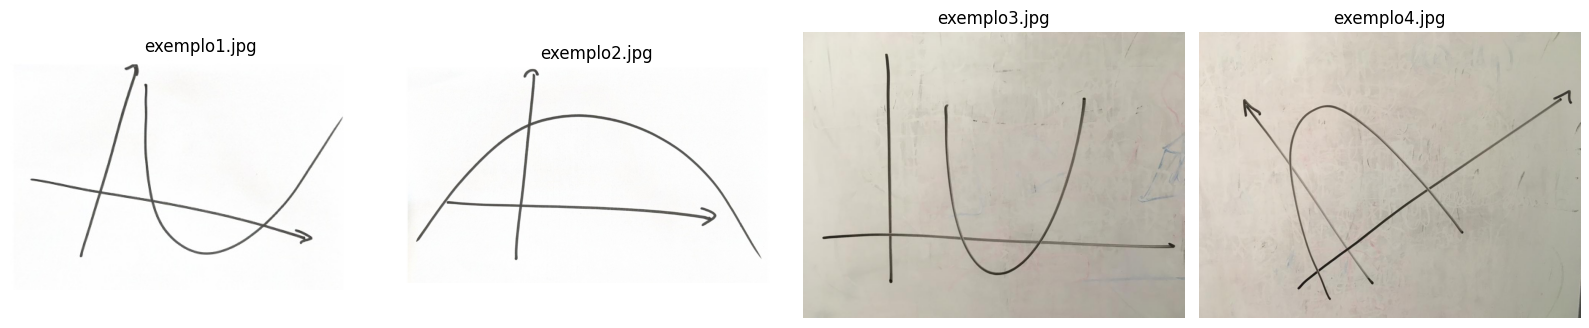

In [ ]:
#
#  Importe as bibliotecas necessárias. Sugere-se usar a versão da Transformada Hough do scikit-image, mas você pode mudar se desejar
#
from skimage.transform import hough_line, hough_line_peaks

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

filenames = [f"exemplo{i}.jpg" for i in range(1, 5)]

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for ax, fname in zip(axes, filenames):
    img = mpimg.imread(fname)
    ax.imshow(img)
    ax.set_title(fname)
    ax.axis('off')

plt.tight_layout()
plt.show()



From this point on, you should proceed with your solution and discussion

**Exercise 1 - Image binarization**

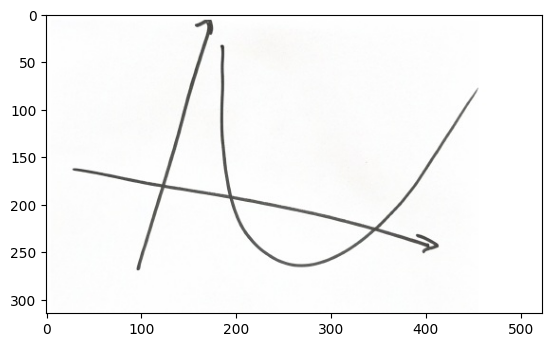

In [ ]:
from skimage import io, color
import numpy as np

img = io.imread("exemplo1.jpg")
plt.imshow(img)
plt.show()

In [ ]:
def to_binary(img, k=1.0):
  imgrey = color.rgb2gray(img)

  mean = np.mean(imgrey)
  std = np.std(imgrey)

  bin = (imgrey < mean - k*std).astype(np.uint8)

  return bin

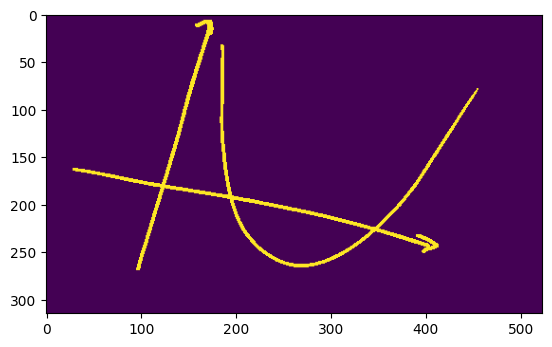

In [ ]:
bin = to_binary(img)

plt.imshow(bin)
plt.show()

Para a binarização da imagem uma análize simples da distribuição da intensidade de cada pizel após a conversão para grayscale se mostrou suficiente, especialmente ao subtrair um desvio padrão da média visto que a os pontos de interresse estão suficientemente distantes da média.

**Exercise 2 - Axis Extraction**

In [ ]:
def get_lines(binmg):
  hspace, angles, distances = hough_line(binmg)
  accums, angle_peaks, dist_peaks = hough_line_peaks(hspace, angles, distances, num_peaks=2)

  return zip(angle_peaks, dist_peaks)

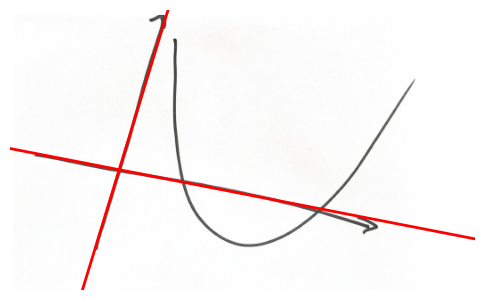

In [ ]:
lines = get_lines(bin)

fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(img)

# draw lines over the original image
for angle, dist in lines:
    x0, x1 = 0, img.shape[1]
    y0 = (dist - x0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - x1 * np.cos(angle)) / np.sin(angle)
    ax.plot((x0, x1), (y0, y1), '-r', linewidth=2)

ax.set_xlim((0, img.shape[1]))
ax.set_ylim((img.shape[0], 0))
ax.axis('off')
plt.show()

Na extração de linhas não houve muitas escolhas diferentes do padrão, apensas a escolha dos dois maiores picos depois da transformado hough usando a implementação sugerida.

**Exercise 3 - Axis removal**

In [ ]:
def remove_axis(lines, binmg, thickness=50):
    bin_img_clean = binmg.copy()
    rows, cols = binmg.shape

    for angle, dist in lines:
        for x in range(cols):
            y = int((dist - x * np.cos(angle)) / np.sin(angle))
            for dy in range(-thickness // 2, thickness // 2 + 1):
                yy = y + dy
                if 0 <= yy < rows:
                    bin_img_clean[yy, x] = 0
    return bin_img_clean


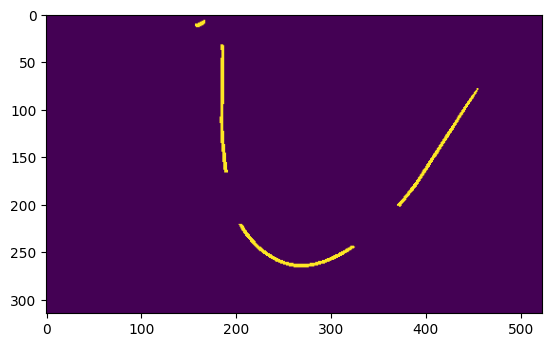

In [ ]:
lines = get_lines(bin)

plotimg = remove_axis(lines, bin)

plt.imshow(plotimg)
plt.show()

A remoção foi feita em cima das linhas extraidas, nesse caso uma abordadegem olhando alguns pixeis acima e abaixo ao percorrer a linha horizontalmente funcionou bem. Porém talvez uma análise mais complexa percorrendo a linha seguindo sua direção e olhando uma banda ortogonal a linha seja mais robusto. Julguei que aqui seria desnecessarimanete complexo.

**Exercise 4 - Rotation**

In [ ]:
def find_intersection(angles, dists):
  # d1 = xcos(a1) + ysin(a1)
  # d2 = xcos(a2) + ysin(a2)
  # Ax = b
  #A = cos/sin a
  #x = (x, y)
  #b = (d1 d2)

  A = np.array([
      [np.cos(angles[0]), np.sin(angles[0])],
      [np.cos(angles[1]), np.sin(angles[1])]
  ])

  b = np.array([dists[0], dists[1]])

  return np.linalg.solve(A, b)

In [ ]:
from skimage.transform import rotate

def correct_rotation(lines, img):
  angles, dists = zip(*lines)
  center = find_intersection(angles, dists)

  rotation = np.degrees(min(angles, key=lambda x: abs(x - np.pi/2)))

  return rotate(img, rotation, center=center, resize=False), center



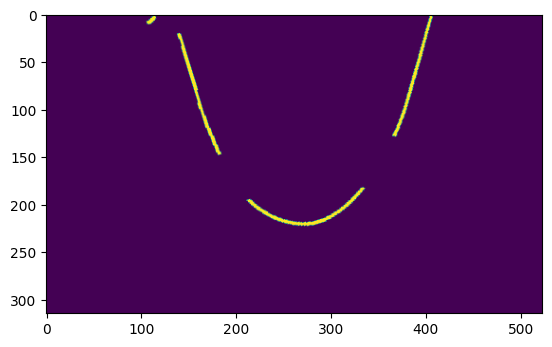

In [ ]:
lines = get_lines(bin)
rotatedimg, center = correct_rotation(lines, plotimg)

plt.imshow(rotatedimg)
plt.show()

Encarmos o problema de achar a intersecção como um sistema linear e achamos o angulo mais próximo de pi meios (horizontal). Apliquei uma funçã do skimage para rotacionar a imagem de acordo com esses parâmetros.

**Exercise 5 - quadratic fit**

In [ ]:
from sklearn.linear_model import LinearRegression, RANSACRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

def fit_quadratic(img):
  ys, xs = np.nonzero(img)
  X = xs[:, np.newaxis]   # shape (N, 1)
  y = ys

  model = make_pipeline(PolynomialFeatures(degree=2), RANSACRegressor(LinearRegression()))
  model.fit(X, y)

  return model, xs, ys


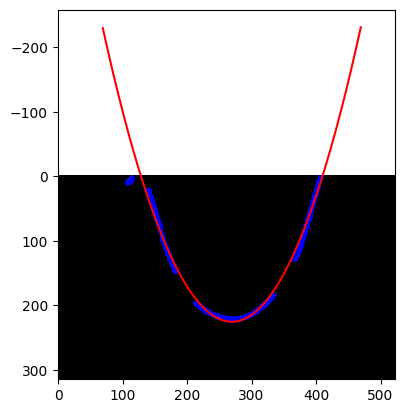

In [ ]:
model, xs, ys = fit_quadratic(rotatedimg)

#generate points
x_fit = np.linspace(xs.mean() - 200, xs.mean() + 200, 500)[:, np.newaxis]
y_fit = model.predict(x_fit)


plt.imshow(rotatedimg, cmap='gray', origin='upper')
plt.scatter(xs, ys, s=1, color='blue')
plt.plot(x_fit, y_fit, color='red')
plt.show()

Fazemos o fit da parabolo de acordo com modelo implementado no sklearn de minimização de erro qudrático em regreção linear, usando o RANSAC para dar ,mais robustes a esse processo em caso de outliers e ruidos vindos da imagem.

**Exercise 6 - final plot**

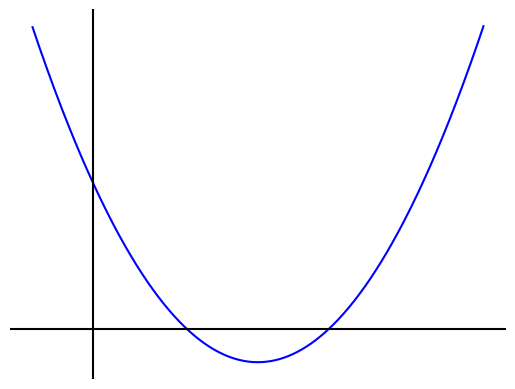

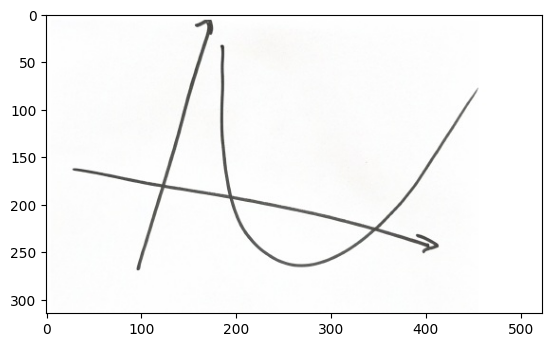

In [ ]:
plt.plot(x_fit, y_fit, color='blue')

# Invert y if needed to match image orientation
plt.gca().invert_yaxis()

# Extract your origin (x0, y0)
x0, y0 = center

# Draw horizontal (x) and vertical (y) axes
plt.axhline(y=y0, color='black')
plt.axvline(x=x0, color='black')

plt.axis("off")
plt.show()

plt.imshow(img)
plt.show()


finalmente plotamos a função encontrada usando o centro do eixos e a função encaixada